# Converting from grid-based to municipality-based

The following steps were done to convert created grid_based dataset to municipality_based one:

import the weight file to a dataframe

assign the values to each grid 

multiply the damaged values with the weights

Aggregate the values by municipality and typhoon_name 

In [1]:
%load_ext jupyter_black

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

from utils import get_training_dataset, weight_file

/Users/mersedehkooshki/opt/anaconda3/envs/global-storm/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Import the created dataset to a df
df = get_training_dataset()
df

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,total_buildings,rainfall_max_6h,rainfall_max_24h,percent_buildings_damaged
0,DURIAN,2006,6301,0.0,510.358125,379.0,0.095833,0.039062,0.0
1,DURIAN,2006,6302,0.0,521.466945,2.0,0.158333,0.101042,0.0
2,DURIAN,2006,6466,0.0,488.030454,38.0,0.033333,0.016146,0.0
3,DURIAN,2006,6467,0.0,499.140454,79.0,0.041667,0.019271,0.0
4,DURIAN,2006,6468,0.0,510.250454,1.0,0.077083,0.043229,0.0
...,...,...,...,...,...,...,...,...,...
98509,MOLAVE,2020,20677,0.0,644.575831,173.0,2.543750,0.778646,0.0
98510,MOLAVE,2020,20678,0.0,655.685233,44.0,2.558333,0.861458,0.0
98511,MOLAVE,2020,20679,0.0,666.794635,13.0,2.975000,0.949479,0.0
98512,MOLAVE,2020,20680,0.0,677.904037,401.0,2.889583,1.083333,0.0


In [4]:
# Read the weight CSV file and import to a df
df_weight_m2c = weight_file("/phl_bld_weight_matrix.csv")
df_weight_m2c.drop("Unnamed: 0", axis=1, inplace=True)

# Convert id columns from float to int
df_weight_m2c["grid_point_id"] = df_weight_m2c["id"].astype(np.int64)
df_weight_m2c.drop(columns="id", inplace=True)
df_weight_m2c

,ADM3_PCODE,ADM3_EN,Centroid,weight,grid_point_id
0,PH175301000,Aborlan,118.3E_9.7N,0.000000,6795
1,PH175301000,Aborlan,118.3E_9.6N,0.004985,6796
2,PH175301000,Aborlan,118.3E_9.5N,0.004487,6797
3,PH175301000,Aborlan,118.3E_9.4N,0.000000,6798
4,PH175301000,Aborlan,118.4E_9.7N,0.152542,6962
...,...,...,...,...,...
9882,PH063047000,Zarraga,122.7E_10.8N,0.042645,14132
9883,PH086023000,Zumarraga,124.9E_11.7N,0.310324,17797
9884,PH086023000,Zumarraga,124.8E_11.7N,0.205268,17630
9885,PH086023000,Zumarraga,124.8E_11.6N,0.239479,17631


In [5]:
# check if weight_sum per municiplaity == 1
agg_m2c = df_weight_m2c.groupby(["ADM3_PCODE"]).agg("sum")
agg_m2c.sort_values("weight", ascending=True)

,weight,grid_point_id
ADM3_PCODE,,
PH175906000,0.0,26053
PH157005000,0.0,59269
PH175321000,0.0,101
PH157011000,0.0,44074
PH157008000,0.0,40648
...,...,...
PH074617000,1.0,30129
PH074622000,1.0,88851
PH074623000,1.0,89393


In [6]:
# values not summing up to 1
agg_m2c[(agg_m2c["weight"] < 0.99)].sort_values("weight", ascending=True)

,weight,grid_point_id
ADM3_PCODE,,
PH157005000,0.0,59269
PH157008000,0.0,40648
PH157011000,0.0,44074
PH175321000,0.0,101
PH175902000,0.0,52100
PH175906000,0.0,26053


In [7]:
# Read the new weight CSV file and import to a df
df_weight = weight_file("/phl_bld_grid_to_municip_matrix.csv")
df_weight.drop("Unnamed: 0", axis=1, inplace=True)

# Convert id columns from float to int
df_weight["grid_point_id"] = df_weight["id"].astype(np.int64)
df_weight.drop(columns="id", inplace=True)
df_weight

,ADM3_PCODE,ADM3_EN,Centroid,weight,grid_point_id
0,PH175301000,Aborlan,118.3E_9.6N,1.000000,6796
1,PH175301000,Aborlan,118.3E_9.5N,1.000000,6797
2,PH175317000,Quezon,118.3E_9.5N,0.000000,6797
3,PH175301000,Aborlan,118.4E_9.7N,0.479624,6962
4,PH175316000,Puerto Princesa City,118.4E_9.7N,0.520376,6962
...,...,...,...,...,...
9291,PH097332000,Zamboanga City,122.3E_7.1N,0.956522,13501
9292,PH097332000,Zamboanga City,122.3E_7.0N,1.000000,13502
9293,PH097332000,Zamboanga City,122.3E_6.9N,1.000000,13503
9294,PH097332000,Zamboanga City,122.4E_7.4N,1.000000,13665


In [8]:
# check if weight_sum per cell == 1
agg_c2m = df_weight.groupby(["grid_point_id"]).agg("sum")
agg_c2m.sort_values("weight", ascending=True)

,weight
grid_point_id,
10515,0.0
10347,0.0
13111,0.0
10008,0.0
11806,0.0
...,...
10434,1.0
13793,1.0
18853,1.0


In [9]:
# values not summing up to 1
agg_c2m[(agg_c2m["weight"] < 0.99) & (agg_c2m["weight"] > 0)].sort_values(
    "weight", ascending=True
)

,weight
grid_point_id,
5471,0.117647
11173,0.191579
10013,0.315217
9846,0.318182
9515,0.348315
...,...
19140,0.989599
7463,0.989704
19490,0.989822


### Following Steps are to convert grid_based model into Municipality based one

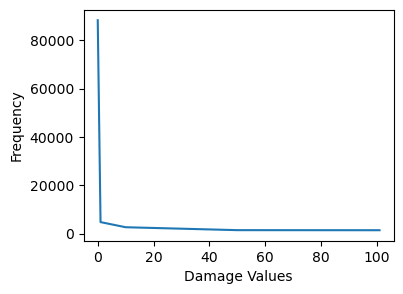

In [10]:
# Hist plot after data stratification
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_buildings_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [11]:
# Check the bins' intervalls
df["percent_buildings_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    88370
(9e-05, 1.0]        4741
(1.0, 10.0]         2616
(10.0, 50.0]        1410
(50.0, 101.0]       1377
Name: percent_buildings_damaged, dtype: int64

In [12]:
# Remove zeros from wind_speed
# df = df[(df[["wind_speed"]] != 0).any(axis=1)]
df_data = df.drop(columns=["grid_point_id", "typhoon_year"])

In [15]:
display(df.head())
display(df_data.head())

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,total_buildings,rainfall_max_6h,rainfall_max_24h,percent_buildings_damaged
0,DURIAN,2006,6301,0.0,510.358125,379.0,0.095833,0.039062,0.0
1,DURIAN,2006,6302,0.0,521.466945,2.0,0.158333,0.101042,0.0
2,DURIAN,2006,6466,0.0,488.030454,38.0,0.033333,0.016146,0.0
3,DURIAN,2006,6467,0.0,499.140454,79.0,0.041667,0.019271,0.0
4,DURIAN,2006,6468,0.0,510.250454,1.0,0.077083,0.043229,0.0


,typhoon_name,wind_speed,track_distance,total_buildings,rainfall_max_6h,rainfall_max_24h,percent_buildings_damaged
0,DURIAN,0.0,510.358125,379.0,0.095833,0.039062,0.0
1,DURIAN,0.0,521.466945,2.0,0.158333,0.101042,0.0
2,DURIAN,0.0,488.030454,38.0,0.033333,0.016146,0.0
3,DURIAN,0.0,499.140454,79.0,0.041667,0.019271,0.0
4,DURIAN,0.0,510.250454,1.0,0.077083,0.043229,0.0


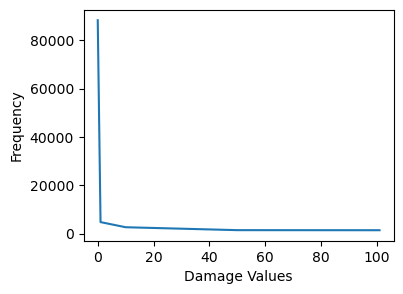

In [16]:
# Hist plot after removing rows where windspeed is 0
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(
    df_data["percent_buildings_damaged"], bins=bins2
)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [17]:
print(samples_per_bin2)
print(binsP2)

[88370  4741  2616  1408  1379]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [18]:
# Check the bins' intervalls
df_data["percent_buildings_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    88370
(9e-05, 1.0]        4741
(1.0, 10.0]         2616
(10.0, 50.0]        1410
(50.0, 101.0]       1377
Name: percent_buildings_damaged, dtype: int64

In [19]:
bin_index2 = np.digitize(df_data["percent_buildings_damaged"], bins=binsP2)

In [20]:
y_input_strat = bin_index2

In [22]:
features = [
    "wind_speed",
    # "track_distance",
    # "total_buildings",
    # "rainfall_max_6h",
    # "rainfall_max_24h"
]

# Split X and y from dataframe features
X = df_data[features]
display(X.columns)
y = df_data["percent_buildings_damaged"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Index(['wind_speed'], dtype='object')

In [23]:
# Define train-test-split function

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    df_data["percent_buildings_damaged"],
    stratify=y_input_strat,
    test_size=0.2,
)

# Define XGBoost Reduced Overfitting model
xgb = XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=0.8,
    colsample_bynode=0.8,
    colsample_bytree=0.8,
    gamma=3,
    eta=0.01,
    importance_type="gain",
    learning_rate=0.1,
    max_delta_step=0,
    max_depth=4,
    min_child_weight=1,
    missing=1,
    n_estimators=100,
    early_stopping_rounds=10,
    n_jobs=1,
    nthread=None,
    objective="reg:squarederror",
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=None,
    silent=None,
    subsample=0.8,
    verbosity=1,
    eval_metric=["rmse", "logloss"],
    random_state=0,
)

eval_set = [(X_test, y_test)]
xgb_model = xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

[14:38:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


                                OLS Regression Results                               
Dep. Variable:     percent_buildings_damaged   R-squared:                       0.172
Model:                                   OLS   Adj. R-squared:                  0.172
Method:                        Least Squares   F-statistic:                 1.638e+04
Date:                       Thu, 19 Jan 2023   Prob (F-statistic):               0.00
Time:                               14:38:48   Log-Likelihood:            -2.9515e+05
No. Observations:                      78811   

In [24]:
# Combine test and training set to have predictiob for all
y_pred_all = xgb.predict(X_scaled)
pred_df = pd.DataFrame(columns=["y_all", "y_pred_all"])
pred_df["y_all"] = df_data["percent_buildings_damaged"]
pred_df["y_pred_all"] = y_pred_all

pred_df

,y_all,y_pred_all
0,0.0,0.11376
1,0.0,0.11376
2,0.0,0.11376
3,0.0,0.11376
4,0.0,0.11376
...,...,...
98509,0.0,0.11376
98510,0.0,0.11376
98511,0.0,0.11376
98512,0.0,0.11376


In [25]:
rmse = sqrt(mean_squared_error(pred_df["y_all"], pred_df["y_pred_all"]))
print(f"RMSE for grid_based model: {rmse:.2f}")

RMSE for grid_based model: 8.87


In [26]:
bin_index = np.digitize(pred_df["y_all"], bins=binsP2)

In [33]:
# Join data with y_all and y_all_pred
df_data_w_pred = pd.merge(pred_df, df_data, left_index=True, right_index=True)
# Join data with grid_point_id typhoon_year
df_data_w_pred_grid = pd.merge(
    df[["grid_point_id", "typhoon_year"]],
    df_data_w_pred,
    left_index=True,
    right_index=True,
)

In [34]:
df_data_w_pred_grid.sort_values("y_pred_all", ascending=False)

,grid_point_id,typhoon_year,y_all,y_pred_all,typhoon_name,wind_speed,track_distance,total_buildings,rainfall_max_6h,rainfall_max_24h,percent_buildings_damaged
21601,14964,2013,89.228159,85.729546,HAIYAN,65.937456,18.755759,2.000000,12.504167,5.881771,89.228159
1458,15439,2006,100.000000,85.729546,DURIAN,65.879707,22.217889,3022.391813,11.393750,6.101562,100.000000
1459,15440,2006,100.000000,85.729546,DURIAN,65.902582,11.108944,7787.833288,13.139583,6.864583,100.000000
90179,16776,2020,14.841810,85.729546,GONI,65.990201,11.369229,843.000000,13.608333,7.158333,14.841810
21497,14125,2013,100.000000,85.729546,HAIYAN,65.972477,14.935688,6602.821887,8.500000,5.541146,100.000000
...,...,...,...,...,...,...,...,...,...,...,...
41702,14116,2014,0.000000,0.113760,LINGLING,0.000000,604.607178,83.000000,0.256250,0.207813,0.000000
41703,14117,2014,0.000000,0.113760,LINGLING,0.000000,599.471305,4.000000,0.254167,0.205208,0.000000
41704,14124,2014,0.000000,0.113760,LINGLING,0.000000,568.322163,7414.000000,0.493750,0.237500,0.000000
41705,14125,2014,0.000000,0.113760,LINGLING,0.000000,564.606943,4001.000000,0.497917,0.207812,0.000000


In [35]:
# join with weights df
join_df = df_data_w_pred_grid.merge(df_weight, on="grid_point_id", how="left")
join_df

,grid_point_id,typhoon_year,y_all,y_pred_all,typhoon_name,wind_speed,track_distance,total_buildings,rainfall_max_6h,rainfall_max_24h,percent_buildings_damaged,ADM3_PCODE,ADM3_EN,Centroid,weight
0,6301,2006,0.0,0.11376,DURIAN,0.0,510.358125,379.0,0.095833,0.039062,0.0,PH175306000,Brooke's Point,118.0E_9.0N,0.000000
1,6301,2006,0.0,0.11376,DURIAN,0.0,510.358125,379.0,0.095833,0.039062,0.0,PH175324000,Sofronio Española,118.0E_9.0N,1.000000
2,6302,2006,0.0,0.11376,DURIAN,0.0,521.466945,2.0,0.158333,0.101042,0.0,PH175306000,Brooke's Point,118.0E_8.9N,0.913043
3,6302,2006,0.0,0.11376,DURIAN,0.0,521.466945,2.0,0.158333,0.101042,0.0,PH175324000,Sofronio Española,118.0E_8.9N,0.086957
4,6466,2006,0.0,0.11376,DURIAN,0.0,488.030454,38.0,0.033333,0.016146,0.0,PH175315000,Narra,118.1E_9.2N,0.756410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275725,20679,2020,0.0,0.11376,MOLAVE,0.0,666.794635,13.0,2.975000,0.949479,0.0,PH112501000,Baganga,126.6E_7.4N,0.153846
275726,20679,2020,0.0,0.11376,MOLAVE,0.0,666.794635,13.0,2.975000,0.949479,0.0,PH112504000,Caraga,126.6E_7.4N,0.846154
275727,20680,2020,0.0,0.11376,MOLAVE,0.0,677.904037,401.0,2.889583,1.083333,0.0,PH112504000,Caraga,126.6E_7.3N,0.982544
275728,20680,2020,0.0,0.11376,MOLAVE,0.0,677.904037,401.0,2.889583,1.083333,0.0,PH112508000,Manay,126.6E_7.3N,0.017456


In [37]:
# Indicate where values are valid and not missing
join_df = join_df.loc[join_df["weight"].notna()]
join_df

,grid_point_id,typhoon_year,y_all,y_pred_all,typhoon_name,wind_speed,track_distance,total_buildings,rainfall_max_6h,rainfall_max_24h,percent_buildings_damaged,ADM3_PCODE,ADM3_EN,Centroid,weight
0,6301,2006,0.0,0.11376,DURIAN,0.0,510.358125,379.0,0.095833,0.039062,0.0,PH175306000,Brooke's Point,118.0E_9.0N,0.000000
1,6301,2006,0.0,0.11376,DURIAN,0.0,510.358125,379.0,0.095833,0.039062,0.0,PH175324000,Sofronio Española,118.0E_9.0N,1.000000
2,6302,2006,0.0,0.11376,DURIAN,0.0,521.466945,2.0,0.158333,0.101042,0.0,PH175306000,Brooke's Point,118.0E_8.9N,0.913043
3,6302,2006,0.0,0.11376,DURIAN,0.0,521.466945,2.0,0.158333,0.101042,0.0,PH175324000,Sofronio Española,118.0E_8.9N,0.086957
4,6466,2006,0.0,0.11376,DURIAN,0.0,488.030454,38.0,0.033333,0.016146,0.0,PH175315000,Narra,118.1E_9.2N,0.756410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275725,20679,2020,0.0,0.11376,MOLAVE,0.0,666.794635,13.0,2.975000,0.949479,0.0,PH112501000,Baganga,126.6E_7.4N,0.153846
275726,20679,2020,0.0,0.11376,MOLAVE,0.0,666.794635,13.0,2.975000,0.949479,0.0,PH112504000,Caraga,126.6E_7.4N,0.846154
275727,20680,2020,0.0,0.11376,MOLAVE,0.0,677.904037,401.0,2.889583,1.083333,0.0,PH112504000,Caraga,126.6E_7.3N,0.982544
275728,20680,2020,0.0,0.11376,MOLAVE,0.0,677.904037,401.0,2.889583,1.083333,0.0,PH112508000,Manay,126.6E_7.3N,0.017456


In [39]:
# Multiply weight by y_all and y_pred_all
join_df["weight*y_pred*buildings"] = (
    join_df["y_pred_all"] * join_df["weight"] * join_df["total_buildings"] / 100
)
join_df["weight*y*buildings"] = (
    join_df["y_all"] * join_df["weight"] * join_df["total_buildings"] / 100
)
join_df["weight*buildings"] = join_df["weight"] * join_df["total_buildings"]
join_df

,grid_point_id,typhoon_year,y_all,y_pred_all,typhoon_name,wind_speed,track_distance,total_buildings,rainfall_max_6h,rainfall_max_24h,percent_buildings_damaged,ADM3_PCODE,ADM3_EN,Centroid,weight,weight*y_pred*buildings,weight*y*buildings,weight*buildings
0,6301,2006,0.0,0.11376,DURIAN,0.0,510.358125,379.0,0.095833,0.039062,0.0,PH175306000,Brooke's Point,118.0E_9.0N,0.000000,0.000000,0.0,0.000000
1,6301,2006,0.0,0.11376,DURIAN,0.0,510.358125,379.0,0.095833,0.039062,0.0,PH175324000,Sofronio Española,118.0E_9.0N,1.000000,0.431149,0.0,379.000000
2,6302,2006,0.0,0.11376,DURIAN,0.0,521.466945,2.0,0.158333,0.101042,0.0,PH175306000,Brooke's Point,118.0E_8.9N,0.913043,0.002077,0.0,1.826087
3,6302,2006,0.0,0.11376,DURIAN,0.0,521.466945,2.0,0.158333,0.101042,0.0,PH175324000,Sofronio Española,118.0E_8.9N,0.086957,0.000198,0.0,0.173913
4,6466,2006,0.0,0.11376,DURIAN,0.0,488.030454,38.0,0.033333,0.016146,0.0,PH175315000,Narra,118.1E_9.2N,0.756410,0.032699,0.0,28.743590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275725,20679,2020,0.0,0.11376,MOLAVE,0.0,666.794635,13.0,2.975000,0.949479,0.0,PH112501000,Baganga,126.6E_7.4N,0.153846,0.002275,0.0,2.000000
275726,20679,2020,0.0,0.11376,MOLAVE,0.0,666.794635,13.0,2.975000,0.949479,0.0,PH112504000,Caraga,126.6E_7.4N,0.846154,0.012514,0.0,11.000000
275727,20680,2020,0.0,0.11376,MOLAVE,0.0,677.904037,401.0,2.889583,1.083333,0.0,PH112504000,Caraga,126.6E_7.3N,0.982544,0.448213,0.0,394.000000
275728,20680,2020,0.0,0.11376,MOLAVE,0.0,677.904037,401.0,2.889583,1.083333,0.0,PH112508000,Manay,126.6E_7.3N,0.017456,0.007963,0.0,7.000000


In [40]:
join_df.sort_values("y_pred_all", ascending=False)

,grid_point_id,typhoon_year,y_all,y_pred_all,typhoon_name,wind_speed,track_distance,total_buildings,rainfall_max_6h,rainfall_max_24h,percent_buildings_damaged,ADM3_PCODE,ADM3_EN,Centroid,weight,weight*y_pred*buildings,weight*y*buildings,weight*buildings
4312,15777,2006,100.000000,85.729546,DURIAN,65.904108,20.312619,8876.617761,10.056250,5.322917,100.000000,PH050509000,Malilipot,123.7E_13.3N,0.409884,3119.169136,3638.382911,3638.382911
4313,15777,2006,100.000000,85.729546,DURIAN,65.904108,20.312619,8876.617761,10.056250,5.322917,100.000000,PH050510000,Malinao,123.7E_13.3N,0.018350,139.640606,162.885041,162.885041
4137,15442,2006,36.328771,85.729546,DURIAN,65.962725,11.072185,15679.000000,12.066667,6.437500,36.328771,PH050514000,Polangui,123.5E_13.4N,0.043672,587.016736,248.754339,684.730955
4136,15442,2006,36.328771,85.729546,DURIAN,65.962725,11.072185,15679.000000,12.066667,6.437500,36.328771,PH051716000,Iriga City,123.5E_13.4N,0.015493,208.243367,88.245254,242.907350
4135,15442,2006,36.328771,85.729546,DURIAN,65.962725,11.072185,15679.000000,12.066667,6.437500,36.328771,PH051705000,Buhi,123.5E_13.4N,0.940836,12646.275350,5358.988385,14751.361696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117680,16137,2014,0.000000,0.113760,LINGLING,0.000000,411.618637,110.000000,1.956250,0.917188,0.000000,PH072247000,Sogod,123.9E_10.7N,0.200000,0.025027,0.000000,22.000000
117681,16137,2014,0.000000,0.113760,LINGLING,0.000000,411.618637,110.000000,1.956250,0.917188,0.000000,PH072252000,Tuburan,123.9E_10.7N,0.490909,0.061430,0.000000,54.000000
117682,16138,2014,0.000000,0.113760,LINGLING,0.000000,409.197507,64.000000,2.250000,0.906771,0.000000,PH072206000,Asturias,123.9E_10.6N,0.000000,0.000000,0.000000,0.000000
117683,16138,2014,0.000000,0.113760,LINGLING,0.000000,409.197507,64.000000,2.250000,0.906771,0.000000,PH072215000,Carmen,123.9E_10.6N,0.152542,0.011106,0.000000,9.762712


In [41]:
# Groupby by municipality and typhoon_name with sum as the aggregation function
agg_df = join_df.groupby(["ADM3_PCODE", "typhoon_name", "typhoon_year"]).agg("sum")

# Normalize by the sum of the weights
agg_df["y_pred_norm"] = (
    agg_df["weight*y_pred*buildings"] / agg_df["weight*buildings"] * 100
)
agg_df["y_norm"] = agg_df["weight*y*buildings"] / agg_df["weight*buildings"] * 100

# Drop not required column y and y_pred before multiplying by weight
agg_df.drop("y_all", axis=1, inplace=True)
agg_df.drop("y_pred_all", axis=1, inplace=True)

agg_df

grid_point_id  wind_speed  \
ADM3_PCODE  typhoon_name typhoon_year                              
PH012801000 BOPHA        2012                  22099   37.687068   
            CONSON       2010                  22099    0.000000   
            DURIAN       2006                  22099    0.000000   
            FENGSHEN     2008                  22099   22.403750   
            FUNG-WONG    2014                  22099   31.238976   
...                                              ...         ...   
PH175917000 USAGI        2013                  39174    0.000000   
            UTOR         2013                  39174    0.000000   
            VAMCO        2020                  39174   39.244147   
            VONGFONG     2020                  39174   26.429974   
            YUTU         2018                  39174    0.000000   

                                       track_distance  total_buildings  \
ADM3_PCODE  typhoon_name typhoon_year                                    
PH012801000 BOPHA        2012              316.190089            904.0   
            CONSON       2010              844.354105            904.0   
            DURIAN       2006             1100.601635            904.0   
            FENGSHEN     2008              574.424649            904.0   
            FUNG-WONG    2014               32.768056            904.0   
...                                               ...              ...   
PH175917000 USAGI        2013             2529.061534            512.0   
            UTOR         2013             1128.281754            512.0   
            VAMCO        2020              771.230647            512.0   
            VONGFONG     2020              352.868347            512.0   
            YUTU         2018             1440.651706            512.0   

                                       rainfall_max_6h  rainfall_max_24h  \
ADM3_PCODE  typhoon_name typhoon_year                                      
PH012801000 BOPHA        2012                 2.502083          1.081548   
            CONSON       2010                 2.370833          0.975000   
            DURIAN       2006                 8.597917          3.081944   
            FENGSHEN     2008                 0.452083          0.232292   
            FUNG-WONG    2014                14.579167         11.186979   
...                                                ...               ...   
PH175917000 USAGI        2013                 6.262500          3.472396   
            UTOR         2013                31.064583          9.348958   
            VAMCO        2020                23.208333         10.819271   
            VONGFONG     2020                 8.916667          4.213021   
            YUTU         2018                 0.333333          0.183854   

                                       percent_buildings_damaged    weight  \
ADM3_PCODE  typhoon_name typhoon_year                                        
PH012801000 BOPHA        2012                           0.000000  1.604396   
            CONSON       2010                           0.000000  1.604396   
            DURIAN       2006                           0.000000  1.604396   
            FENGSHEN     2008                           0.000000  1.604396   
            FUNG-WONG    2014                           0.077922  1.604396   
...                                                          ...       ...   
PH175917000 USAGI        2013                           0.000000  1.122621   
            UTOR         2013                           0.000000  1.122621   
            VAMCO        2020                           0.000000  1.122621   
            VONGFONG     2020                           0.000000  1.122621   
            YUTU         2018                           0.000000  1.122621   

                                       weight*y_pred*buildings  \
ADM3_PCODE  typhoon_name typhoon_year                            
PH012801000 BOPHA        2012                         3

In [42]:
# agg_df.isnull().values.any()

# Remove rows with NaN after normalization
final_df = agg_df.dropna()
final_df

grid_point_id  wind_speed  \
ADM3_PCODE  typhoon_name typhoon_year                              
PH012801000 BOPHA        2012                  22099   37.687068   
            CONSON       2010                  22099    0.000000   
            DURIAN       2006                  22099    0.000000   
            FENGSHEN     2008                  22099   22.403750   
            FUNG-WONG    2014                  22099   31.238976   
...                                              ...         ...   
PH175917000 USAGI        2013                  39174    0.000000   
            UTOR         2013                  39174    0.000000   
            VAMCO        2020                  39174   39.244147   
            VONGFONG     2020                  39174   26.429974   
            YUTU         2018                  39174    0.000000   

                                       track_distance  total_buildings  \
ADM3_PCODE  typhoon_name typhoon_year                                    
PH012801000 BOPHA        2012              316.190089            904.0   
            CONSON       2010              844.354105            904.0   
            DURIAN       2006             1100.601635            904.0   
            FENGSHEN     2008              574.424649            904.0   
            FUNG-WONG    2014               32.768056            904.0   
...                                               ...              ...   
PH175917000 USAGI        2013             2529.061534            512.0   
            UTOR         2013             1128.281754            512.0   
            VAMCO        2020              771.230647            512.0   
            VONGFONG     2020              352.868347            512.0   
            YUTU         2018             1440.651706            512.0   

                                       rainfall_max_6h  rainfall_max_24h  \
ADM3_PCODE  typhoon_name typhoon_year                                      
PH012801000 BOPHA        2012                 2.502083          1.081548   
            CONSON       2010                 2.370833          0.975000   
            DURIAN       2006                 8.597917          3.081944   
            FENGSHEN     2008                 0.452083          0.232292   
            FUNG-WONG    2014                14.579167         11.186979   
...                                                ...               ...   
PH175917000 USAGI        2013                 6.262500          3.472396   
            UTOR         2013                31.064583          9.348958   
            VAMCO        2020                23.208333         10.819271   
            VONGFONG     2020                 8.916667          4.213021   
            YUTU         2018                 0.333333          0.183854   

                                       percent_buildings_damaged    weight  \
ADM3_PCODE  typhoon_name typhoon_year                                        
PH012801000 BOPHA        2012                           0.000000  1.604396   
            CONSON       2010                           0.000000  1.604396   
            DURIAN       2006                           0.000000  1.604396   
            FENGSHEN     2008                           0.000000  1.604396   
            FUNG-WONG    2014                           0.077922  1.604396   
...                                                          ...       ...   
PH175917000 USAGI        2013                           0.000000  1.122621   
            UTOR         2013                           0.000000  1.122621   
            VAMCO        2020                           0.000000  1.122621   
            VONGFONG     2020                           0.000000  1.122621   
            YUTU         2018                           0.000000  1.122621   

                                       weight*y_pred*buildings  \
ADM3_PCODE  typhoon_name typhoon_year                            
PH012801000 BOPHA        2012                         3

In [43]:
# Calculate RMSE in total for converted grid_based model to Mun_based

rmse = sqrt(mean_squared_error(final_df["y_norm"], final_df["y_pred_norm"]))
print(f"RMSE for grid_based model: {rmse:.2f}")

RMSE for grid_based model: 7.65


In [44]:
bin_index = np.digitize(final_df["y_norm"], bins=binsP2)

### Calculate RMSE per bin for converted grid_based model to Mun_based

In [45]:
# Define a function to estimate RMSE per bin


def rmse_bin(n):
    mse = mean_squared_error(
        final_df["y_norm"][bin_index == n],
        final_df["y_pred_norm"][bin_index == n],
    )
    rmse = np.sqrt(mse)
    print(f"RMSE per bin_{n}: {rmse:.2f}")


for bin_num in range(1, 6):
    rmse_bin(bin_num)

RMSE per bin_1: 1.54
RMSE per bin_2: 7.15
RMSE per bin_3: 11.62
RMSE per bin_4: 19.62
RMSE per bin_5: 58.32


### Check if y_norm is the the same as the damage ground truth in the original model

In [47]:
# Read the weight CSV file and import to df
df_old_data = pd.read_csv("data/old_data.csv")
df_old_data.drop("Unnamed: 0", axis=1, inplace=True)
df_old_data.columns = df_old_data.columns.str.replace("Mun_Code", "ADM3_PCODE")
df_old_data.head()

,ADM3_PCODE,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3
0,PH175101000,durian2006,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,...,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568,166667.757548
1,PH083701000,durian2006,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,...,1.218595,13.645253,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000,664.968323
2,PH015501000,durian2006,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,...,0.667374,15.592295,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000,1311.358762
3,PH015502000,durian2006,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,...,0.675125,7.100454,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000,1775.385328
4,PH175302000,durian2006,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,...,0.821288,30.354796,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000,1211.676901


In [48]:
# Capitalize strings typhoon column and change the typhoon column's name
for i in range(len(df_old_data)):
    df_old_data.at[i, "typhoon_name"] = df_old_data.loc[i, "typhoon"].upper()

del df_old_data["typhoon"]
df_old_data

,ADM3_PCODE,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,...,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3,typhoon_name
0,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,2.64,...,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568,166667.757548,DURIAN2006
1,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,0.06,...,13.645253,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000,664.968323,DURIAN2006
2,PH015501000,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,1.52,...,15.592295,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000,1311.358762,DURIAN2006
3,PH015502000,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,0.00,...,7.100454,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000,1775.385328,DURIAN2006
4,PH175302000,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,5.52,...,30.354796,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000,1211.676901,DURIAN2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,PH084823000,9.700000,0.408333,0.216146,8.136932,277.107823,1.80,6.25,6.25,1.80,...,32.492212,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411,0.000000,538.743551,NOUL2015
8069,PH015547000,17.587500,1.414583,0.386458,9.818999,305.789817,0.00,0.00,0.00,0.00,...,4.703833,0.027875,0.000000,0.034843,0.097561,1.073268,12.766551,0.000000,946.676507,NOUL2015
8070,PH025014000,11.487500,0.614583,0.230319,15.791907,210.313249,0.06,0.09,0.09,0.06,...,3.063753,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952,0.000000,3938.254316,NOUL2015
8071,PH140127000,11.600000,1.400000,0.412766,13.867145,218.189328,0.00,0.00,0.00,0.00,...,3.119093,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166,0.000000,2666.620370,NOUL2015


In [49]:
df_old_data["typhoon_year"] = df_old_data["typhoon_name"].str[-4:]
df_old_data["typhoon_name"] = df_old_data["typhoon_name"].str[:-4]
df_old_data["typhoon_year"] = df_old_data["typhoon_year"].astype("int64")
df_old_data

,ADM3_PCODE,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,...,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3,typhoon_name,typhoon_year
0,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,2.64,...,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568,166667.757548,DURIAN,2006
1,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,0.06,...,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000,664.968323,DURIAN,2006
2,PH015501000,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,1.52,...,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000,1311.358762,DURIAN,2006
3,PH015502000,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,0.00,...,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000,1775.385328,DURIAN,2006
4,PH175302000,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,5.52,...,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000,1211.676901,DURIAN,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,PH084823000,9.700000,0.408333,0.216146,8.136932,277.107823,1.80,6.25,6.25,1.80,...,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411,0.000000,538.743551,NOUL,2015
8069,PH015547000,17.587500,1.414583,0.386458,9.818999,305.789817,0.00,0.00,0.00,0.00,...,0.027875,0.000000,0.034843,0.097561,1.073268,12.766551,0.000000,946.676507,NOUL,2015
8070,PH025014000,11.487500,0.614583,0.230319,15.791907,210.313249,0.06,0.09,0.09,0.06,...,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952,0.000000,3938.254316,NOUL,2015
8071,PH140127000,11.600000,1.400000,0.412766,13.867145,218.189328,0.00,0.00,0.00,0.00,...,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166,0.000000,2666.620370,NOUL,2015


In [50]:
# Remove year from typhoons' name
# for i in range(len(df_old_data)):
#    if df_old_data.at[i, "typhoon_name"] == "GONI2015":
#        df_old_data.loc[i, "typhoon_name"] = "GONI2015"

#    elif df_old_data.at[i, "typhoon_name"] == "GONI2020":
#        df_old_data.loc[i, "typhoon_name"] = "GONI2020"

#    else:
#        df_old_data.loc[i, "typhoon_name"] = df_old_data.loc[i, "typhoon_name"][:-4]
# df_old_data

In [51]:
agg_df_old_data = df_old_data.groupby(["ADM3_PCODE"]).agg("sum")
agg_df_old_data

,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,GEN_Red_per_LSbldg,...,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3,typhoon_year
ADM3_PCODE,,,,,,,,,,,,,,,,,,,,,
PH012801000,1540.191667,69.743056,40.703450,267.204204,1137.195510,36.72,0.00,0.00,36.72,36.72,...,21.897810,0.000000,0.000000,0.000000,0.000000,22.098214,370.072993,0.973236,713418.086535,18135
PH012802000,1567.800000,66.133333,41.231272,289.548362,1116.545916,14.10,15.40,15.40,14.10,0.00,...,4.535441,0.000000,0.129584,0.000000,0.259168,5.370169,83.322535,1.399508,600411.585560,20145
PH012803000,1482.887500,84.754167,44.353513,260.810168,1188.415514,24.50,16.80,16.80,24.50,0.40,...,65.408805,0.279525,0.000000,0.000000,0.419287,14.581225,208.106219,7.491265,366336.115659,20147
PH012804000,1714.850000,92.071667,46.335691,341.286734,998.382173,28.80,15.10,15.10,28.80,4.10,...,26.032824,1.697793,0.000000,0.000000,0.000000,11.177754,149.405772,1.245048,878159.265616,20144
PH012805000,2049.008333,94.663258,56.398160,287.371061,1908.790607,0.39,0.39,0.39,0.39,0.39,...,24.425008,0.210560,0.105280,0.000000,0.000000,7.865800,178.660512,0.688371,419859.619693,26190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PH175913000,369.121429,32.132143,13.755053,61.168774,155.821370,7.08,4.22,4.22,7.08,3.16,...,67.657694,0.281237,0.361591,1.084773,0.160707,6.016072,62.394536,1.004419,61326.291421,4028
PH175914000,97.650000,5.802273,3.454654,82.724509,705.502314,0.00,0.00,0.00,0.00,0.00,...,156.085320,0.501882,0.000000,0.000000,0.167294,16.101461,137.348390,3.429527,87982.096558,8056
PH175915000,265.100000,14.297424,8.030009,94.082701,879.185712,0.00,0.00,0.00,0.00,0.00,...,240.314278,0.135465,0.000000,0.000000,0.000000,21.990309,173.530209,2.898943,64533.566739,10070


In [52]:
df_merged = df_old_data.merge(
    final_df,
    how="left",
    on=["ADM3_PCODE", "typhoon_name", "typhoon_year"],
)

df_merged

,ADM3_PCODE,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,...,total_buildings,rainfall_max_6h,rainfall_max_24h,percent_buildings_damaged,weight,weight*y_pred*buildings,weight*y*buildings,weight*buildings,y_pred_norm,y_norm
0,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,2.64,...,6112.617995,137.925000,66.310417,135.871639,6.702179,1080.840699,237.803793,5298.118835,20.400462,4.488457
1,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,0.06,...,16956.000000,3.960417,2.168750,0.000000,4.133899,21.468383,0.000000,7648.811153,0.280676,0.000000
2,PH015501000,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,1.52,...,233.000000,6.777083,2.959375,0.000000,0.320594,0.105706,0.000000,24.185207,0.437069,0.000000
3,PH015502000,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,0.00,...,638.000000,7.993750,2.531771,0.000000,0.692145,0.255585,0.000000,58.477000,0.437069,0.000000
4,PH175302000,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,5.52,...,707.000000,6.135417,2.985937,0.000000,6.000000,3.090079,0.000000,707.000000,0.437069,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,PH084823000,9.700000,0.408333,0.216146,8.136932,277.107823,1.80,6.25,6.25,1.80,...,10655.000000,2.133333,1.173437,0.000000,0.997690,6.034257,0.000000,1691.705864,0.356697,0.000000
8069,PH015547000,17.587500,1.414583,0.386458,9.818999,305.789817,0.00,0.00,0.00,0.00,...,346.000000,2.443750,1.075833,0.000000,0.308642,0.044183,0.000000,38.839308,0.113760,0.000000
8070,PH025014000,11.487500,0.614583,0.230319,15.791907,210.313249,0.06,0.09,0.09,0.06,...,660.000000,1.275000,0.460119,0.000000,0.394312,0.541966,0.000000,124.000000,0.437069,0.000000
8071,PH140127000,11.600000,1.400000,0.412766,13.867145,218.189328,0.00,0.00,0.00,0.00,...,815.000000,4.652083,1.325521,0.000000,0.149041,0.234675,0.000000,53.692902,0.437069,0.000000


In [53]:
print(df_merged["DAM_perc_dmg"].corr(df_merged["y_norm"]))
print(df_merged["DAM_perc_dmg"].corr(df_merged["y_pred_norm"]))

0.6006045455434368
0.6584013097924344


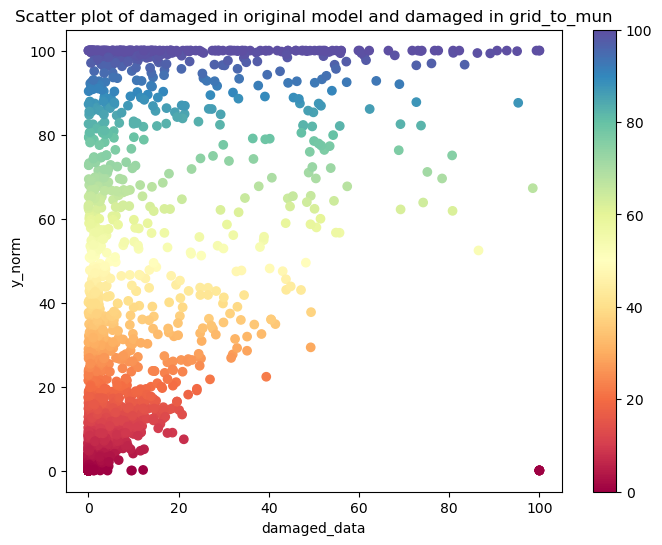

In [54]:
x = df_merged["DAM_perc_dmg"]
y = df_merged["y_norm"]
plt.rcParams.update({"figure.figsize": (8, 6), "figure.dpi": 100})
plt.scatter(x, y, c=y, cmap="Spectral")
plt.colorbar()
plt.title("Scatter plot of damaged in original model and damaged in grid_to_mun")
plt.xlabel("damaged_data")
plt.ylabel("y_norm")
plt.show()

In [57]:
# df_merged.isnull().sum()
df_merged_2 = df_merged.dropna()

In [59]:
df_merged_2.reset_index(drop=True, inplace=True)
df_merged_2

,ADM3_PCODE,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,...,total_buildings,rainfall_max_6h,rainfall_max_24h,percent_buildings_damaged,weight,weight*y_pred*buildings,weight*y*buildings,weight*buildings,y_pred_norm,y_norm
0,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,2.64,...,6112.617995,137.925000,66.310417,135.871639,6.702179,1080.840699,237.803793,5298.118835,20.400462,4.488457
1,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,0.06,...,16956.000000,3.960417,2.168750,0.000000,4.133899,21.468383,0.000000,7648.811153,0.280676,0.000000
2,PH015501000,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,1.52,...,233.000000,6.777083,2.959375,0.000000,0.320594,0.105706,0.000000,24.185207,0.437069,0.000000
3,PH015502000,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,0.00,...,638.000000,7.993750,2.531771,0.000000,0.692145,0.255585,0.000000,58.477000,0.437069,0.000000
4,PH175302000,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,5.52,...,707.000000,6.135417,2.985937,0.000000,6.000000,3.090079,0.000000,707.000000,0.437069,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7937,PH084823000,9.700000,0.408333,0.216146,8.136932,277.107823,1.80,6.25,6.25,1.80,...,10655.000000,2.133333,1.173437,0.000000,0.997690,6.034257,0.000000,1691.705864,0.356697,0.000000
7938,PH015547000,17.587500,1.414583,0.386458,9.818999,305.789817,0.00,0.00,0.00,0.00,...,346.000000,2.443750,1.075833,0.000000,0.308642,0.044183,0.000000,38.839308,0.113760,0.000000
7939,PH025014000,11.487500,0.614583,0.230319,15.791907,210.313249,0.06,0.09,0.09,0.06,...,660.000000,1.275000,0.460119,0.000000,0.394312,0.541966,0.000000,124.000000,0.437069,0.000000
7940,PH140127000,11.600000,1.400000,0.412766,13.867145,218.189328,0.00,0.00,0.00,0.00,...,815.000000,4.652083,1.325521,0.000000,0.149041,0.234675,0.000000,53.692902,0.437069,0.000000


In [60]:
for i in range(len(df_merged_2)):
    if df_merged_2.loc[i, "DAM_perc_dmg"] == df_merged_2.loc[i, "y_norm"]:
        df_merged_2.at[i, "compare"] = "True"
    elif df_merged_2.loc[i, "DAM_perc_dmg"] != df_merged_2.loc[i, "y_norm"]:
        df_merged_2.at[i, "compare"] = "False"


df_merged_2

/var/folders/sx/c10hm4fj3glf7mw1_mzwcl700000gn/T/ipykernel_38561/1146880797.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_2.at[i, "compare"] = "False"


,ADM3_PCODE,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,...,rainfall_max_6h,rainfall_max_24h,percent_buildings_damaged,weight,weight*y_pred*buildings,weight*y*buildings,weight*buildings,y_pred_norm,y_norm,compare
0,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,2.64,...,137.925000,66.310417,135.871639,6.702179,1080.840699,237.803793,5298.118835,20.400462,4.488457,False
1,PH083701000,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,0.06,...,3.960417,2.168750,0.000000,4.133899,21.468383,0.000000,7648.811153,0.280676,0.000000,True
2,PH015501000,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,1.52,...,6.777083,2.959375,0.000000,0.320594,0.105706,0.000000,24.185207,0.437069,0.000000,True
3,PH015502000,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,0.00,...,7.993750,2.531771,0.000000,0.692145,0.255585,0.000000,58.477000,0.437069,0.000000,True
4,PH175302000,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,5.52,...,6.135417,2.985937,0.000000,6.000000,3.090079,0.000000,707.000000,0.437069,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7937,PH084823000,9.700000,0.408333,0.216146,8.136932,277.107823,1.80,6.25,6.25,1.80,...,2.133333,1.173437,0.000000,0.997690,6.034257,0.000000,1691.705864,0.356697,0.000000,True
7938,PH015547000,17.587500,1.414583,0.386458,9.818999,305.789817,0.00,0.00,0.00,0.00,...,2.443750,1.075833,0.000000,0.308642,0.044183,0.000000,38.839308,0.113760,0.000000,True
7939,PH025014000,11.487500,0.614583,0.230319,15.791907,210.313249,0.06,0.09,0.09,0.06,...,1.275000,0.460119,0.000000,0.394312,0.541966,0.000000,124.000000,0.437069,0.000000,True
7940,PH140127000,11.600000,1.400000,0.412766,13.867145,218.189328,0.00,0.00,0.00,0.00,...,4.652083,1.325521,0.000000,0.149041,0.234675,0.000000,53.692902,0.437069,0.000000,True


In [61]:
df_merged_2 = df_merged_2[~df_merged_2.select_dtypes(["object"]).eq("True").any(1)]
df_merged_2

,ADM3_PCODE,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,GEN_Bu_p_LS,...,rainfall_max_6h,rainfall_max_24h,percent_buildings_damaged,weight,weight*y_pred*buildings,weight*y*buildings,weight*buildings,y_pred_norm,y_norm,compare
0,PH175101000,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,2.64,...,137.925000,66.310417,135.871639,6.702179,1080.840699,237.803793,5298.118835,20.400462,4.488457,False
6,PH043401000,137.825000,11.141667,5.282292,45.946435,58.003453,0.00,0.00,0.00,0.00,...,41.166667,19.604167,8.021315,0.087309,69.355549,0.840227,564.659888,12.282712,0.148802,False
15,PH035403000,34.700000,2.976389,1.373264,17.959482,180.568781,0.00,0.00,0.00,0.00,...,30.135417,13.460417,9.517873,1.693508,176.321324,0.233320,30498.494397,0.578131,0.000765,False
17,PH054101000,153.995000,14.470833,6.238125,23.682962,103.825021,3.10,3.37,3.37,3.10,...,190.525000,81.559896,0.443087,7.873036,72.643649,1.876602,3573.175155,2.033028,0.052519,False
20,PH051701000,187.387500,12.754167,6.935417,69.095429,3.822421,0.00,0.05,0.05,0.00,...,48.800000,26.645833,400.000000,1.336799,2899.830926,3606.508076,3606.508076,80.405502,100.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7600,PH020906000,297.450000,20.550000,11.245833,60.682289,36.716509,9.05,0.90,0.90,9.05,...,39.439583,23.023958,11.339369,0.217618,212.526883,19.011866,272.757985,77.917749,6.970232,False
7733,PH020903000,169.225000,18.904167,7.112766,54.379415,13.322384,10.98,0.00,0.00,10.90,...,36.531250,13.757812,0.246570,0.466040,87.515263,0.427301,403.590387,21.684179,0.105875,False
7888,PH021523000,113.950000,9.426852,4.442080,63.460137,9.357787,1.44,18.88,18.80,1.44,...,82.377083,40.402604,4.368067,8.152994,4573.396345,46.247196,9528.809958,47.995462,0.485341,False
7898,PH021525000,84.687500,6.039583,3.543085,38.632415,54.779271,2.31,15.20,15.20,2.31,...,23.985417,14.080729,0.198877,1.345279,321.400335,2.210484,4282.980688,7.504128,0.051611,False


In [62]:
print(df_merged_2["DAM_perc_dmg"].corr(df_merged_2["y_norm"]))

0.5679421820775596


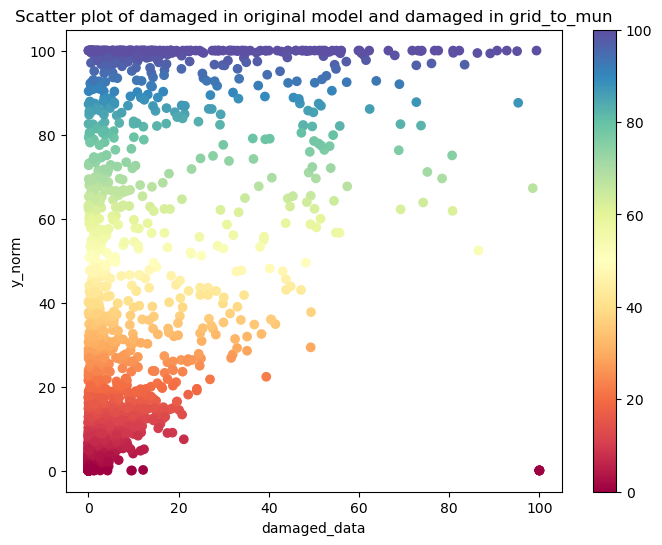

In [63]:
x = df_merged_2["DAM_perc_dmg"]
y = df_merged_2["y_norm"]
plt.rcParams.update({"figure.figsize": (8, 6), "figure.dpi": 100})
plt.scatter(x, y, c=y, cmap="Spectral")
plt.colorbar()
plt.title("Scatter plot of damaged in original model and damaged in grid_to_mun")
plt.xlabel("damaged_data")
plt.ylabel("y_norm")
plt.show()

Text(0, 0.5, 'Frequency')

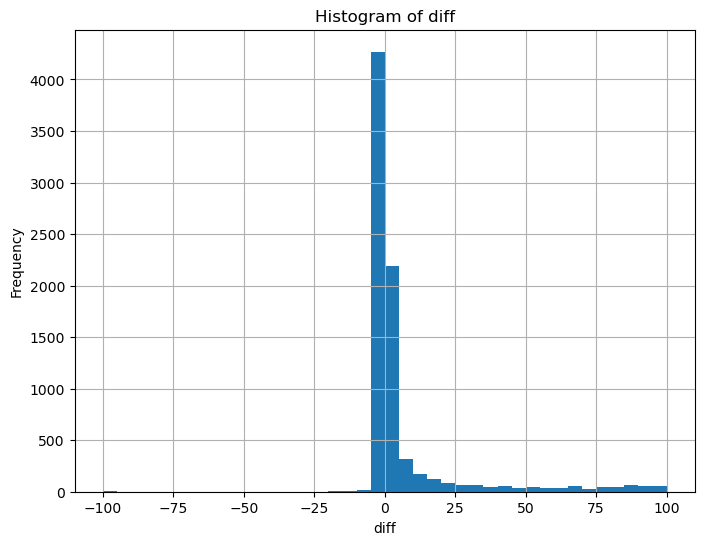

In [64]:
diff = df_merged["y_norm"] - df_merged["DAM_perc_dmg"]
diff.hist(bins=40, figsize=(8, 6))
plt.title("Histogram of diff")
plt.xlabel("diff")
plt.ylabel("Frequency")